# All figures of the paperdraft

In [6]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.gridspec import GridSpec
import os

from cycler import cycler
# Color blind safe from here https://sronpersonalpages.nl/~pault/
# tol_bright_colors = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677', '#AA3377', '#BBBBBB'][::2]
tol_bright_colors = ['#4477AA', '#228833', '#CCBB44', '#EE6677', '#AA3377']
plt.rc('axes', prop_cycle=cycler('color', tol_bright_colors))



def get_experiment_base_path():
    notebook_dir = Path(os.path.dirname(os.path.abspath("__file__")))
    experiment_base_path = notebook_dir / "../experiments/"
    return experiment_base_path

def get_output_fig_path():
    notebook_dir = Path(os.path.dirname(os.path.abspath("__file__")))
    output_fig_path = notebook_dir / "../figures/"
    return output_fig_path



with open(get_experiment_base_path() / 'paperdraft.json', 'r') as f:
    experiment_dict = json.load(f)

def get_experiment_path(experiment):
    return get_experiment_base_path() / experiment_dict[experiment]['experiment_path']

def get_metrics_dict(experiment):
    with open(get_experiment_path(experiment) / 'ensemble_metrics.json', 'r') as f:
        return json.load(f)
    
data_base_path = Path(os.path.dirname(os.path.abspath("__file__"))) / '../../data_publication/datasets/'

In [2]:
import pandas as pd
from pathlib import Path
from datetime import datetime
from torch.utils.data import DataLoader
from amoc_reconstruction.reconstruction.dataset import merge_profiles_max_profiles
from amoc_reconstruction.reconstruction.dataset import load_merged_argo_dataset_and_tumo_cycles, filter_ds_argo_data, split_dataset_into_training_validation_testing_profile_datasets

In [7]:
### PARAMETERS

smoothing_days = 90
time_smoothing = f'{smoothing_days}D'
lat_bounds = (25, 30)

target_reference_level = 4800
missing_values_in_target = False

using_missing_indices = False
using_transport_from_previous_year = False
use_deep_dvdz = False
deep_argo = True

geostrophic_prediction = False


train_batch_sizes = {
    '10D': 32,
    '30D': 16,
    '90D': 8,
    '365D': 4,
}


n_compartments_for_smoothing = {
    '10D': 49,
    '30D': 3,
    '90D': 9,
    '365D': 42,
}

train_batch_size = train_batch_sizes[time_smoothing]

add_tmp = False
add_sal = False

test_start_year = 2005
test_end_year = 2025

validation_years_on_each_side = 10


random_split_data = False

assert target_reference_level in [2000, 4800], "Only 2000 and 4800 are supported as reference levels"
version = 'v5'
n_compartments = n_compartments_for_smoothing[time_smoothing]
n_embedding = 8

distance_assignment_module  = 'distance'



dataset_path = data_base_path / Path( f'smoothing_{smoothing_days}_days/argo_after_2012/paperdraft/')
total_moc_path = data_base_path /  Path('moc_total/')
antilles_current_path = data_base_path /  Path('antilles_current/')
florida_current_path = data_base_path /  Path('florida_current/')
wind_stress_path = data_base_path /  Path('windstress/')

ref_folder = f'{abs(target_reference_level)}m_ref'

compartments = [
        ['west_p', -76.74, -70, 'west'],
        ['mar_west_p', -60, -47, 'east'],
        ['mar_east_p', -47, -40, 'west'],
        ['east_p', -30, -13.5, 'east']
    ]


device = 'cpu'


assert version in ['v2', 'v3', 'v4', 'v5']
assert distance_assignment_module in ['distance', 'fixed']



In [9]:



ds_argo_merged, t_umo_obs, ds_pos_sim, dv_dz_obs, t_delta, total_moc, antilles_current, florida_current, wind_stress, backwards_timeshift = load_merged_argo_dataset_and_tumo_cycles(
    # ['1st_7020', '2nd_5820', '3rd_5820', '4th_5820', '5th_5820', '6th_5820'],
    ['1st_7024'],
    dataset_path,
    ref_folder,
    total_moc_path,
    antilles_current_path,
    florida_current_path,
    wind_stress_path,
    time_smoothing,
    deep_argo,
    missing_values_in_target
)


ds_argo_merged = filter_ds_argo_data(ds_argo_merged, deep_argo)





train_dataset, val_dataset, test_dataset, (total_moc_mean, total_moc_std, geostrophic_moc_mean, geostorphic_moc_std) = split_dataset_into_training_validation_testing_profile_datasets(
    False, test_start_year, test_end_year, validation_years_on_each_side, t_umo_obs, ds_argo_merged, add_tmp, add_sal, deep_argo, False, total_moc, florida_current, antilles_current, wind_stress, dv_dz_obs, missing_values_in_target, ds_pos_sim, compartments, time_smoothing, lat_bounds, using_transport_from_previous_year, using_missing_indices, use_deep_dvdz, backwards_timeshift
)


dl = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=merge_profiles_max_profiles, num_workers=0)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=merge_profiles_max_profiles, num_workers=0)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=merge_profiles_max_profiles, num_workers=0)


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/p

142 218 2005-03-28T00:00:00.000000000 2023-12-19T00:00:00.000000000
101 41 77


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/numpy/lib/nanfunctions.py

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(train_dataset.dv_dz)

# reduced_values = pca.transform(dv_dz_obs.dv_dz_times_X.sel(z = slice(None, -2000)).values)
reduced_values = TSNE(n_components=2).fit_transform(dv_dz_obs.dv_dz_times_X.sel(z = slice(None, -2000)).values)


## Figure Performance

/tmp/ipykernel_102011/4146606191.py:199: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


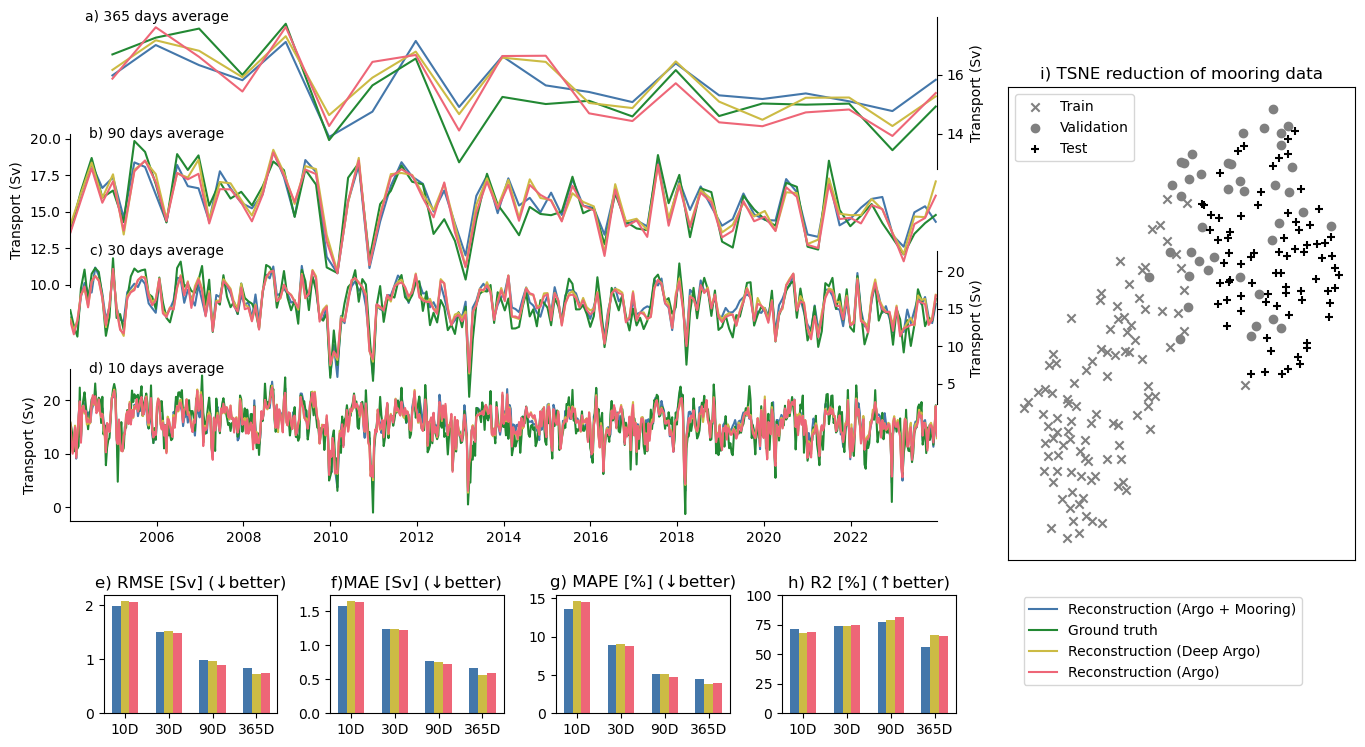

In [11]:


test_predictions_mooring_10d = xr.open_dataset(get_experiment_path('001') / 'ensemble_predictions.nc').mean('member')
test_predictions_mooring_30d = xr.open_dataset(get_experiment_path('002') / 'ensemble_predictions.nc').mean('member')
test_predictions_mooring_90d = xr.open_dataset(get_experiment_path('003') / 'ensemble_predictions.nc').mean('member')
test_predictions_mooring_365d = xr.open_dataset(get_experiment_path('004') / 'ensemble_predictions.nc').mean('member')

test_predictions_deep_10d = xr.open_dataset(get_experiment_path('016') / 'ensemble_predictions.nc').mean('member')
test_predictions_deep_30d = xr.open_dataset(get_experiment_path('017') / 'ensemble_predictions.nc').mean('member')
test_predictions_deep_90d = xr.open_dataset(get_experiment_path('018') / 'ensemble_predictions.nc').mean('member')
test_predictions_deep_365d = xr.open_dataset(get_experiment_path('019') / 'ensemble_predictions.nc').mean('member')

test_predictions_none_10d = xr.open_dataset(get_experiment_path('020') / 'ensemble_predictions.nc').mean('member')
test_predictions_none_30d = xr.open_dataset(get_experiment_path('021') / 'ensemble_predictions.nc').mean('member')
test_predictions_none_90d = xr.open_dataset(get_experiment_path('022') / 'ensemble_predictions.nc').mean('member')
test_predictions_none_365d = xr.open_dataset(get_experiment_path('023') / 'ensemble_predictions.nc').mean('member')

axes_width = .6

min_time = min(
    test_predictions_mooring_10d.time.min(),
    test_predictions_mooring_30d.time.min(),
    test_predictions_mooring_90d.time.min(),
    test_predictions_mooring_365d.time.min(),

)

max_time = max(
    test_predictions_mooring_10d.time.max(),
    test_predictions_mooring_30d.time.max(),
    test_predictions_mooring_90d.time.max(),
    test_predictions_mooring_365d.time.max(),
)

fig = plt.figure(figsize=(13,7))
text_pos_x, text_pos_y = 0.1,1

base_height = .33
overlap_percentage = .1
delta = (1 - base_height)


height_per_plot = delta * (1 + 3 * overlap_percentage) / 4
axes_width = 4 / 6

gs = GridSpec(2,5, figure=fig, height_ratios=[4,1],   width_ratios=[1,1,1,1,2])
ax = fig.add_axes([0, base_height + (delta / 4) * 0, axes_width, height_per_plot])

ax.plot(test_predictions_mooring_10d.time, test_predictions_mooring_10d.test_predictions, label = 'Reconstruction (Argo + Mooring)')
ax.plot(test_predictions_mooring_10d.time, test_predictions_mooring_10d.test_gt_transport, label='Ground truth')
ax.plot(test_predictions_deep_10d.time, test_predictions_deep_10d.test_predictions, label = 'Reconstruction (Deep Argo)')
ax.plot(test_predictions_none_10d.time, test_predictions_none_10d.test_predictions, label = 'Reconstruction (Argo)')


# remove the x-axis and also the border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# ax.set_xticks([])

# ax.legend(loc = 'lower right')
ax.legend(bbox_to_anchor=(1.1, -.5), loc='upper left', borderaxespad=0.)

ax.set_xlim(min_time.values, max_time.values)
ax.text(text_pos_x, text_pos_y, 'd) 10 days average', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


ax.set_ylabel('Transport (Sv)')


ax = fig.add_axes([0, base_height + (delta / 4) * 1, axes_width, height_per_plot])


ax.plot(test_predictions_mooring_30d.time, test_predictions_mooring_30d.test_predictions, label = 'Reconstruction')
# ax.plot(test_predictions_deep_30d.time, test_predictions_deep_30d.test_predictions, label='Reconstruction (Deep Argo)')
ax.plot(test_predictions_mooring_30d.time, test_predictions_mooring_30d.test_gt_transport, label='Ground truth')
ax.plot(test_predictions_deep_30d.time, test_predictions_deep_30d.test_predictions, label = 'Reconstruction (Deep Argo)')
ax.plot(test_predictions_none_30d.time, test_predictions_none_30d.test_predictions, label = 'Reconstruction (Argo)')


# remove the x-axis and also the border
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False) 
ax.spines['bottom'].set_visible(False)

ax.set_xticks([])
ax.set_xlim(min_time.values, max_time.values)
ax.text(text_pos_x, text_pos_y, 'c) 30 days average', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

#set y axis on right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_facecolor('none')
ax.set_ylabel('Transport (Sv)')

ax = fig.add_axes([0, base_height + (delta / 4) * 2, axes_width, height_per_plot])

ax.plot(test_predictions_mooring_90d.time, test_predictions_mooring_90d.test_predictions, label = 'Reconstruction')
# ax.plot(test_predictions_deep_90d.time, test_predictions_deep_90d.test_predictions, label='Reconstruction (Deep Argo)')
ax.plot(test_predictions_mooring_90d.time, test_predictions_mooring_90d.test_gt_transport, label='Ground truth')
ax.plot(test_predictions_deep_90d.time, test_predictions_deep_90d.test_predictions, label = 'Reconstruction (Deep Argo)')
ax.plot(test_predictions_none_90d.time, test_predictions_none_90d.test_predictions, label = 'Reconstruction (Argo)')

# remove the x-axis and also the border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks([])

ax.set_ylabel('Transport (Sv)')

#set background color to transparent
ax.set_facecolor('none')
ax.set_xlim(min_time.values, max_time.values)
ax.text(text_pos_x, text_pos_y, 'b) 90 days average', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

ax = fig.add_axes([0, base_height + (delta / 4) * 3, axes_width, height_per_plot])

ax.plot(test_predictions_mooring_365d.time, test_predictions_mooring_365d.test_predictions, label = 'Reconstruction')
# ax.plot(test_predictions_deep_90d.time, test_predictions_deep_90d.test_predictions, label='Reconstruction (Deep Argo)')
ax.plot(test_predictions_mooring_365d.time, test_predictions_mooring_365d.test_gt_transport, label='Ground truth')
ax.plot(test_predictions_deep_365d.time, test_predictions_deep_365d.test_predictions, label = 'Reconstruction (Deep Argo)')
ax.plot(test_predictions_none_365d.time, test_predictions_none_365d.test_predictions, label = 'Reconstruction (Argo)')

# remove the x-axis and also the border
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks([])

ax.set_ylabel('Transport (Sv)')

#set background color to transparent
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_facecolor('none')
ax.set_xlim(min_time.values, max_time.values)
ax.text(text_pos_x, text_pos_y, 'a) 365 days average', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# fig.tight_layout()


# plt.savefig('../rapid-geostrophic-reconstruction/figs/transport_reconstruction.png', dpi=300)

# save complete figure

# fig.savefig('../rapid-geostrophic-reconstruction/figs/transport_reconstruction.png', dpi=300)

values = [
    (1, get_metrics_dict('001'), get_metrics_dict('016'), get_metrics_dict('020'), 10),
    (2, get_metrics_dict('002'), get_metrics_dict('017'), get_metrics_dict('021'), 30),
    (3, get_metrics_dict('003'), get_metrics_dict('018'), get_metrics_dict('022'), 90),
    (4, get_metrics_dict('004'), get_metrics_dict('019'), get_metrics_dict('023'), 365),
]

def plot_metrics(variable_name, ax, scale = 1, charachter='xxx'):
    ax.bar([i[0] - .2 for i in values],[i[1]['original']['mean'][variable_name] *scale for i in values ], label = f'{variable_name} Argo + Mooring', width = .2)
    # skip one color
    ax.bar([i[0] for i in values if i[2] is not None ],[i[2]['original']['mean'][variable_name] *scale for i in values if i[2] is not None], label = f'{variable_name} Deep Argo', width = .2, alpha = 0)
    ax.bar([i[0] for i in values if i[2] is not None ],[i[2]['original']['mean'][variable_name] *scale for i in values if i[2] is not None], label = f'{variable_name} Deep Argo', width = .2)
    ax.bar([i[0] +.2 for i in values if i[3] is not None ],[i[3]['original']['mean'][variable_name] *scale for i in values if i[3] is not None], label = f'{variable_name} Argo', width = .2)
    ax.set_xticks([i[0] for i in values])
    ax.set_xticklabels([f'{i[-1]}D' for i in values])
    # ax.add_patch(plt.Rectangle((0.045, 0.09), .105, .2, fc='white', edgecolor='black', lw=1.5,  transform=ax.transAxes))
    # ax.text(0.1, 0.18, f'{charachter})', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    if variable_name == 'R2':
        ax.set_ylim(0, 100)


ax = fig.add_subplot(gs[1,0])
plot_metrics('RMSE', ax, charachter='e')    
ax.set_title('e) RMSE [Sv] (↓better)')

ax = fig.add_subplot(gs[1,1])
plot_metrics('MAE', ax, charachter='f')
ax.set_title('f)MAE [Sv] (↓better)')

ax = fig.add_subplot(gs[1,2])
plot_metrics('MAPE', ax, 100, charachter='g')
ax.set_title('g) MAPE [%] (↓better)')

ax = fig.add_subplot(gs[1,3])
plot_metrics('R2', ax, 100, charachter='h')
ax.set_title('h) R2 [%] (↑better)')


ax = fig.add_subplot(gs[0,4])
ax.scatter(reduced_values[train_dataset.global_indices,0], reduced_values[train_dataset.global_indices,1], label = 'Train', c = 'gray', marker='x')
ax.scatter(reduced_values[val_dataset.global_indices,0], reduced_values[val_dataset.global_indices,1], label = 'Validation', c = 'gray', marker='o')
ax.scatter(reduced_values[test_dataset.global_indices,0], reduced_values[test_dataset.global_indices,1], label = 'Test', c = 'black', marker='+')
ax.legend()

ax.set_title('i) TSNE reduction of mooring data')
ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()
fig.savefig(get_output_fig_path() / '05_transport_depth.png', dpi=300, bbox_inches='tight')